# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_recall_fscore_support
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, VotingClassifier
import joblib
import warnings

In [2]:
tf.random.set_seed(10)
df = pd.read_csv("creditcard.csv")
data = df.to_numpy()
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [169]:
X_train, X_test, y_train, y_test = train_test_split(
    data[:,:-1], data[:,-1],
    test_size=0.4,
    random_state=10,
    shuffle=True,
)

In [3]:
# custom metrics
def score(y_true, y_pred, beta=1.0):
    tp = 0
    fp = 0
    fn = 0
    for t, p in zip(y_true, y_pred):
        if p > 0.5:
            p = 1
        else:
            p = 0
        if t == p and t == 1:
            tp += 1
        elif t != p and p == 1:
            fp += 1
        elif t != p and p == 0:
            fn += 1
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = (1 + beta ** 2) * precision * recall / (beta ** 2 * precision + recall)
    return precision, recall, f1

# Data Visualization

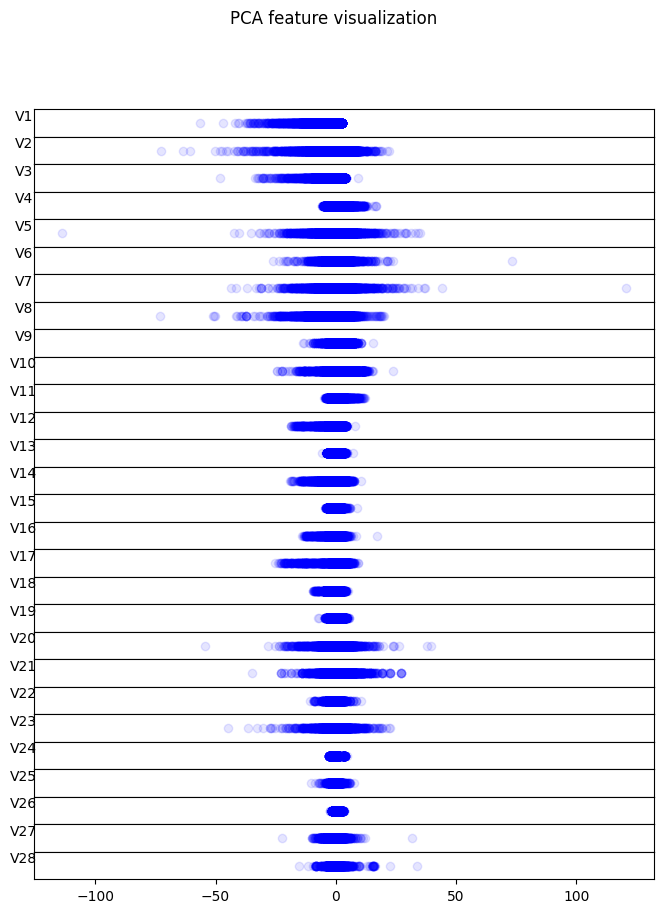

In [4]:
fig, axs = plt.subplots(28, 1, sharex=True)
fig.subplots_adjust(hspace=0)
fig.set_size_inches(8, 10)
fig.suptitle("PCA feature visualization")

for i in range(1, 29):
    axs[i-1].plot(data[:, i], np.zeros(data.shape[0]), 'bo', alpha=0.1)
    #axs[i-1].set_xticks([])
    axs[i-1].set_yticks([])
    axs[i-1].set_ylabel('V'+str(i), rotation=0)
plt.show()

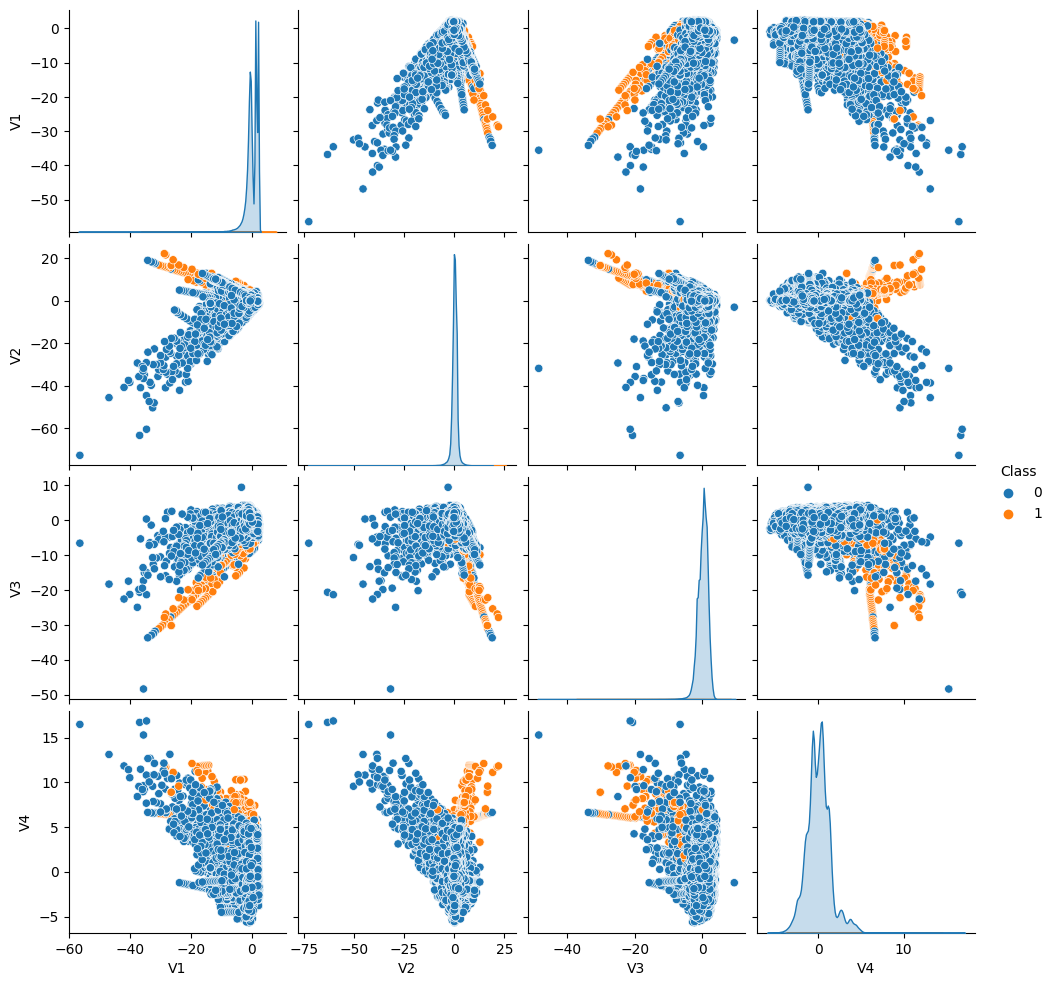

In [5]:
df_sub = df[['V1', 'V2', 'V3', 'V4', 'Class']].copy()
p = sns.pairplot(df_sub, hue="Class")

# Logistic Regression

In [170]:
min_select = 4
cv = StratifiedKFold(5)
LR = LogisticRegression(max_iter=1000, solver='newton-cholesky')
rfecv = RFECV(
    estimator=LogisticRegression(),
    cv=cv,
    scoring='f1',
    min_features_to_select=min_select,
    n_jobs=-1)

LR_clf=Pipeline([('Scaler', StandardScaler()), ('rfecv', rfecv)])
LR_clf.fit(X_train, y_train)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('rfecv',
                 RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                       estimator=LogisticRegression(), min_features_to_select=4,
                       n_jobs=-1, scoring='f1'))])

In [171]:
preds = LR_clf.predict(X_test)
LR_score = score(y_test, preds, 2.0)
print("Precision:", LR_score[0])
print("Recall:", LR_score[1])
print("f1:", LR_score[2])

Precision: 0.8832116788321168
Recall: 0.6368421052631579
f1: 0.6744704570791525


In [32]:
# save LR_clf
joblib.dump(LR_clf, 'LR.pkl')

['LR.pkl']

In [25]:
# load LR_clf
LR_clf = joblib.load('Lr.pkl')

Reduction of data from RFE

In [85]:
ranking = LR_clf.named_steps['rfecv'].ranking_
feature_importance = LR_clf.named_steps['rfecv'].estimator_.coef_[0]

In [86]:
ranking

array([ 1,  9,  4,  1,  1,  1,  1,  1,  1,  1,  1,  3,  1,  1,  1,  1, 12,
        7,  5,  1,  1,  1,  8, 11, 10,  6,  1,  2,  1])

In [87]:
unique, count = np.unique(ranking, return_counts=True)
counts = dict(zip(unique, count))
n = counts[1] 
print(n, "best features")

18 best features


In [89]:
feature_importance_sorted = sorted(enumerate(feature_importance), key=lambda x: x[1])
top_n_idx = [idx for idx, _ in feature_importance_sorted[:n]]

# ANN

In [172]:
# normalize data
X = data[:,:-1]
y = data[:,-1]
X_mean = X.mean()
X_std = X.std()
X_norm = (X - X_mean) / X_std

In [173]:
X_train, X_test, y_train, y_test = train_test_split(
    X_norm, y,
    test_size=0.4,
    random_state=25,
    shuffle=True,
)

In [174]:
input_features = X.shape[1]
batch_sizes = [1, 10, 20, 64]

In [55]:
metrics = dict()
for batch_size in batch_sizes:
    ANN = Sequential()
    ANN.add(Dense(3*(input_features+1)//20, activation='relu', input_shape=(input_features,)))
    ANN.add(Dense(1, activation='sigmoid'))
    ANN.compile(optimizer='adam', loss=losses.BinaryCrossentropy())
    ANN.fit(X_train, y_train,
             epochs=15,
             batch_size=batch_size,
             verbose=0
             )
    preds = ANN.predict(X_test)
    metrics[batch_size] = score(y_test, preds, 2.0)

3561/3561 [==============================] - 3s 826us/step


In [56]:
print(metrics)

{1: (0.8620689655172413, 0.7575757575757576, 0.7763975155279502), 10: (0.8923076923076924, 0.5858585858585859, 0.6290672451193058), 20: (0.8722222222222222, 0.7929292929292929, 0.8076131687242797), 64: (0.8579545454545454, 0.7626262626262627, 0.7799586776859503)}


In [175]:
ANN = Sequential()
ANN.add(Dense(3*(input_features+1)//20, activation='relu', input_shape=(input_features,)))
ANN.add(Dense(1, activation='sigmoid'))
ANN.compile(optimizer='adam', loss=losses.BinaryCrossentropy())
history = ANN.fit(X_train, y_train,
       epochs=25,
       batch_size=20,
        verbose=0,
        validation_data=(X_test, y_test))


In [127]:
print(ANN.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 120       
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 125
Trainable params: 125
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
preds = ANN.predict(X_test)
ANN_score = score(y_test, preds, 2.0)
print("Precision:", ANN_score[0])
print("Recall:", ANN_score[1])
print("f1:", ANN_score[2])

3561/3561 [==============================] - 3s 928us/step
Precision: 0.8688524590163934
Recall: 0.803030303030303
f1: 0.8153846153846154


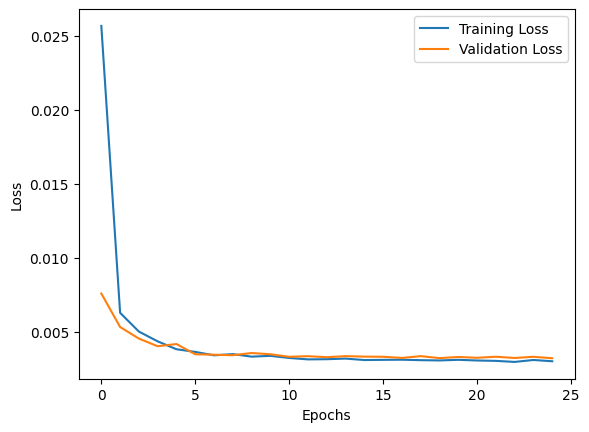

In [176]:
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

In [12]:
# save network
ANN.save("ANN.keras")

In [26]:
# load network
ANN = tf.keras.models.load_model("ANN.keras")

# SVC

In [216]:
X = data[:,:-1]
y = data[:,-1]
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.4,
    random_state=527,
    shuffle=True,
)

In [217]:
C_range = [0.02, 0.2, 2, 20]
param_grid = [{'SVC__C':C_range, 'SVC':[SVC()]}]
cv = StratifiedKFold(5, shuffle=True, random_state=148)
clf = Pipeline([('Scaler', StandardScaler()), ('SVC', SVC())])
SVC_grid = GridSearchCV(clf, param_grid=param_grid, cv=cv, scoring='recall')
SVC_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=148, shuffle=True),
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('SVC', SVC())]),
             param_grid=[{'SVC': [SVC(C=2)], 'SVC__C': [0.02, 0.2, 2, 20]}],
             scoring='recall')

In [218]:
print("RBF kernel with best gamma and C:", SVC_grid.best_params_, "with score:", SVC_grid.best_score_)

RBF kernel with best gamma and C: {'SVC': SVC(C=2), 'SVC__C': 2} with score: 0.6061581920903955


In [219]:
gamma_range = np.logspace(-3, 0, 4) / X_train.shape[1]
for i, g in enumerate(gamma_range):
    print(i, g)
    clf = Pipeline([('Scaler', StandardScaler()), ('SVC', SVC(gamma=g, C=2))])
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    print(score(y_test, preds, 2.0))

0 3.4482758620689657e-05
(0.8351648351648352, 0.7794871794871795, 0.79002079002079)
1 0.0003448275862068966
(0.8229166666666666, 0.8102564102564103, 0.8127572016460906)
2 0.003448275862068966
(0.8681318681318682, 0.8102564102564103, 0.8212058212058213)
3 0.034482758620689655
(0.9423076923076923, 0.7538461538461538, 0.7852564102564102)


In [220]:
SVC_clf = Pipeline([('Scaler', StandardScaler()), ('SVC', SVC(C=2, gamma=0.1/X_train.shape[1]))])
SVC_clf.fit(X_train, y_train)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('SVC', SVC(C=2, gamma=0.003448275862068966))])

In [36]:
preds = SVC_clf.predict(X_test)
SVC_score = score(y_test, preds, 2.0)
print("Precision:", SVC_score[0])
print("Recall:", SVC_score[1])
print("f1:", SVC_score[2])

Precision: 0.8571428571428571
Recall: 0.8021390374331551
f1: 0.8125677139761646


In [60]:
# save pipeline
joblib.dump(SVC_clf, 'SVC.pkl')

['SVC.pkl']

In [205]:
# load pipeline
SVC_clf = joblib.load('SVC.pkl')

# kNN

In [202]:
# using reduced data to improve computation time and f1 score
X_train, X_test, y_train, y_test = train_test_split(
    data[:,:-1][:, top_n_idx], data[:,-1],
    test_size=0.4,
    random_state=10,
    shuffle=True,
)
print(X_train.shape)

(170884, 18)


In [203]:
n_range = [2, 3, 4, 5]
p_range = [1, 2]
param_grid = dict(p=p_range, n_neighbors=n_range)
kNN_grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, scoring='recall', cv=10)
kNN_grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5], 'p': [1, 2]},
             scoring='recall')

In [204]:
print("Best parameters:", kNN_grid.best_params_, "with score:", kNN_grid.best_score_)

Best parameters: {'n_neighbors': 3, 'p': 1} with score: 0.785268817204301


In [206]:
kNN = KNeighborsClassifier(n_neighbors=3, p=1)

In [207]:
kNN.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3, p=1)

In [208]:
preds = kNN.predict(X_test)
kNN_score = score(y_test, preds, 2.0)

In [209]:
print("Precision:", kNN_score[0])
print("Recall:", kNN_score[1])
print("f1:", kNN_score[2])

Precision: 0.9559748427672956
Recall: 0.8
f1: 0.8269858541893362


# Random Forest

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    data[:,:-1], data[:,-1],
    test_size=0.4,
    random_state=7,
    shuffle=True,
)

In [5]:
# DT parameters
depth_ranges = [10, 12, 14]
# Bagging parameters
n_estimators_range = [125, 250, 500]
max_samples_range = [0.7, 0.8, 0.9]
max_features_range = [0.8, 0.9, 1.0]

In [6]:
model = {'model': BaggingClassifier,
         'kwargs': {'base_estimator': DecisionTreeClassifier()},
         'parameters': {
             'bag__base_estimator__max_depth': depth_ranges,
             'bag__n_estimators' : n_estimators_range,
             'bag__max_samples' : max_samples_range,
             'bag__max_features' : max_features_range
         }}
pipeline = Pipeline([('bag', model['model'](**model['kwargs'], bootstrap=True, n_jobs=-1, oob_score=True))])
cv = StratifiedKFold(5, shuffle=True, random_state=148)
bag_grid =  GridSearchCV(pipeline, param_grid=model['parameters'], cv=cv, scoring='f1')
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    bag_grid.fit(X_train, y_train)

In [7]:
print("Best parameters:", bag_grid.best_params_, "with score:", bag_grid.best_score_)

Best parameters: {'bag__base_estimator__max_depth': 14, 'bag__max_features': 0.8, 'bag__max_samples': 0.9, 'bag__n_estimators': 125} with score: 0.8569402939360955


In [8]:
bag_clf = BaggingClassifier(
         DecisionTreeClassifier(splitter="random", max_depth=14),
         n_estimators=125, max_samples=0.9, max_features=0.8,
        bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=14,
                                                   splitter='random'),
                  max_features=0.8, max_samples=0.9, n_estimators=125,
                  n_jobs=-1, oob_score=True)

In [9]:
preds = bag_clf.predict(X_test)
bag_score = score(y_test, preds, 2.0)

In [10]:
print("Precision:", bag_score[0])
print("Recall:", bag_score[1])
print("f1:", bag_score[2])

Precision: 0.9457831325301205
Recall: 0.8351063829787234
f1: 0.8551198257080611


In [11]:
# save bag
joblib.dump(bag_clf, 'bag.pkl')

['bag.pkl']

In [10]:
# load bag
bag_clf = joblib.load('bag.pkl')

# Custom Ensemble Classifier

In [210]:
X_train, X_test, y_train, y_test = train_test_split(
    data[:,1:-1], data[:,-1],
    test_size=0.4,
    random_state=37,
    shuffle=True,
)

In [211]:
class ELclf(object):
    def __init__(self, classifiers):
        self.n_clfs = len(classifiers)
        self.clfs = dict()
        self.weighted_preds = np.array([])
        self.weight_sum = 0
        self.preds = np.array([])
        for name, clf, score in classifiers:
            self.clfs[name] = {
                'name':name,
                'clf':clf,
                'precision':score[0],
                'recall':score[1],
                'f1':score[2]
            }
    
    def predict(self, X_test):
        self.weighted_preds = np.zeros(X_test.shape[0]).reshape(-1,)
        self.weight_sum = 0
        for model, d in self.clfs.items():
            if not model in {'ANN','kNN'}:
                d['preds'] = d['clf'].predict(X_test) 
            elif model == 'kNN':
                X_red = X_test[:, top_n_idx]
                d['preds'] = d['clf'].predict(X_red) 
            else:
                X = (X_test - X_mean) / X_std
                preds = d['clf'].predict(X)
                d['preds'] = np.array([1. if p >= 0.5 else 0. for p in preds]).reshape(-1,) 
            # self.weighted_preds = self.weighted_preds + d['preds'] * d['recall']
            self.weighted_preds = self.weighted_preds + d['preds']
            # self.weight_sum += d['recall']
            print(model, 'prediction complete.')
        # self.preds = self.weighted_preds / self.weight_sum
        self.preds = self.weighted_preds / self.n_clfs
        self.preds = np.array([1. if p >= 0.2 else 0. for p in self.preds]).reshape(-1,)
        return self.preds
            
        
    def score(self, y_true):
        for model, d in self.clfs.items():
            model_score = score(y_true, d['preds'], 2.0)
            print(model, "\n\tPrecision:", model_score[0],
                 "\n\tRecall:   ", model_score[1],
                 "\n\tf1:       ", model_score[2])
        el_score = score(y_true, self.preds, 2.0)
        return el_score  

In [212]:
clfs = [('LR', LR_clf, LR_score),
        ('ANN', ANN, ANN_score), 
        ('SVC', SVC_clf, SVC_score), 
        ('kNN', kNN, kNN_score), 
        ('Bagging clf', bag_clf, bag_score)]
el_clf = ELclf(clfs)

In [213]:
preds = el_clf.predict(X_test)

LR prediction complete.
3561/3561 [==============================] - 3s 756us/step
ANN prediction complete.
SVC prediction complete.
kNN prediction complete.
Bagging clf prediction complete.


In [214]:
el_score = el_clf.score(y_test)

LR 
	Precision: 0.8702290076335878 
	Recall:    0.6195652173913043 
	f1:        0.657439446366782
ANN 
	Precision: 0.8539325842696629 
	Recall:    0.8260869565217391 
	f1:        0.8315098468271335
SVC 
	Precision: 0.8444444444444444 
	Recall:    0.8260869565217391 
	f1:        0.8296943231441049
kNN 
	Precision: 0.9743589743589743 
	Recall:    0.8260869565217391 
	f1:        0.852017937219731
Bagging clf 
	Precision: 0.9753086419753086 
	Recall:    0.8586956521739131 
	f1:        0.8797327394209353


In [215]:
print("EL Precision:", el_score[0])
print("EL Recall:   ", el_score[1])
print("EL f1:       ", el_score[2])

EL Precision: 0.8181818181818182
EL Recall:    0.8804347826086957
EL f1:        0.867237687366167
